In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import statistics


#Following packages are needed
import folium
from folium.features import DivIcon
%matplotlib inline
import pandas as pd
import re
import os
import branca.colormap as cm
import re
import math

import geopy.distance
from ipynb.fs.full.Angle import py_ang
from ipynb.fs.full.race_timestamps import start_and_end_of_start
from os.path import exists as file_exists

pd.set_option("max_rows", None)
pd.set_option("max_columns", None)

# Overview
>
>This notebook is investigatin ggate bias more in detail. We look at whether different boats chooses gate bias more often than other boats. We look at the best possible time to call gate bias.  
>
>* **1 What boats chooses biased gate?**
> * **2. When to call gate bias?**
> * **3 Create a column that determinnes if boat is passed half way (has gybes on the first downwind)**
> * **4. Can we call gate bias on the reach?**
> * **5. Call gate bias on same leg but before first gybe downwind?**
> * **6. Conclusion**

In [2]:
df = pd.read_csv('df_merged2.csv')
df=df.loc[~df['TRK_RACE_NUM_unk'].isnull()]
df['DATETIME']=pd.to_datetime(df['DATETIME'])
df['date_column'] = pd.to_datetime(df['DATETIME']).dt.date
#Dont want to look at final races
df = df.loc[df['extra']!=6.0]


In [3]:
df.head()

,BOAT,DATETIME,Latitude,Longitude,BSP_kmh,TWS_kmh,TWD,TWD_TM_deg,TWA,TRK_RACE_NUM_unk,TRK_LEG_NUM_unk,PC_TTB_s,PC_TTK_s,TTS_s,extra,unk_race_ID,POSITION_AT_LAST_MARK*,DELTA,date_column,WW_gate_vectors_first,WW_gate_vectors_second,LW_gate_vectors_first,LW_gate_vectors_second,WG1_long,WG1_lat,WG2_long,WG2_lat,LG1_long,LG1_lat,LG2_long,LG2_lat,Place,dist_betwen_LW_marks,dist_betwen_WW_marks,u_wind_vectorTWD,v_wind_vectorTWD,rel_wind_angle_LWgateTWD,rel_wind_angle_WWgateTWD,avg_leg_TWA,avg_leg_TWA_next_leg,mtr_gain_by_LG1TWD,mtr_gain_by_WG2TWD,median_TWD,u_wind_vectormedian_TWD,v_wind_vectormedian_TWD,rel_wind_angle_LWgatemedian_TWD,rel_wind_angle_WWgatemedian_TWD,mtr_gain_by_LWG1median_TWD,mtr_gain_by_WWG2median_TWD,boat_to_LG1,boat_to_WG1,boat_to_LG2,boat_to_WG2,take_LWG1,take_LWG2,take_WWG1,take_WWG2,dist_to_mark_after_rounding,meters_won,take_biased_gate,boats_won_on_leg_after_gate
0,GBR,2022-06-18 19:12:01,41.888381,-87.590905,15.72,28.88,344.71,340.19,-147.26,22061801.0,0.0,146.06,102.95,119.40,1.0,2022-06-18 19:12:01,NaN,-77.0,2022-06-18,-7.44,0.024,-21.825,-0.9,-87.594043,41.891106,-87.595903,41.891112,-87.593217,41.876205,-87.595642,41.876105,chicago,270.9,207.7,7.615792,-27.857748,102.9,105.5,NaN,NaN,0.0,0.0,352.340,3.849540,-28.622289,95.3,97.8,0.0,0.0,264.5,350.7,532.2,558.4,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN
1,CAN,2022-06-18 19:12:01,41.888182,-87.592916,61.08,25.33,0.40,357.96,-73.31,22061801.0,0.0,65.12,116.65,119.50,1.0,2022-06-18 19:12:01,NaN,-3.0,2022-06-18,-7.44,0.024,-21.825,-0.9,-87.594043,41.891106,-87.595903,41.891112,-87.593217,41.876205,-87.595642,41.876105,chicago,270.9,207.7,-0.176835,-25.329383,87.2,89.8,NaN,NaN,0.0,0.0,352.200,3.437675,-25.095643,95.4,98.0,0.0,0.0,65.5,126.7,309.7,333.9,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN
2,SUI,2022-06-18 19:12:01,41.887851,-87.593025,34.13,23.18,2.67,357.32,-52.18,22061801.0,0.0,89.70,115.65,119.50,1.0,2022-06-18 19:12:01,NaN,-9.0,2022-06-18,-7.44,0.024,-21.825,-0.9,-87.594043,41.891106,-87.595903,41.891112,-87.593217,41.876205,-87.595642,41.876105,chicago,270.9,207.7,-1.079804,-23.154836,85.0,87.5,NaN,NaN,0.0,0.0,351.565,3.400212,-22.929260,96.1,98.6,0.0,0.0,58.7,114.7,297.4,321.8,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN
3,AUS,2022-06-18 19:12:01,41.886923,-87.596583,19.70,22.68,358.01,356.70,-40.47,22061801.0,0.0,119.72,98.65,118.60,1.0,2022-06-18 19:12:01,NaN,-15.0,2022-06-18,-7.44,0.024,-21.825,-0.9,-87.594043,41.891106,-87.595903,41.891112,-87.593217,41.876205,-87.595642,41.876105,chicago,270.9,207.7,0.787565,-22.666322,89.6,92.2,NaN,NaN,0.0,0.0,352.250,3.058419,-22.472839,95.4,97.9,0.0,0.0,379.4,284.4,116.7,78.5,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN
4,ESP,2022-06-18 19:12:01,41.883369,-87.597178,21.51,23.96,356.86,6.35,-31.50,22061801.0,0.0,295.43,58.15,118.65,1.0,2022-06-18 19:12:01,NaN,-5.0,2022-06-18,-7.44,0.024,-21.825,-0.9,-87.594043,41.891106,-87.595903,41.891112,-87.593217,41.876205,-87.595642,41.876105,chicago,270.9,207.7,1.312431,-23.924028,90.8,93.3,NaN,NaN,0.0,0.0,353.730,2.616764,-23.816678,93.9,96.5,0.0,0.0,443.7,352.1,174.9,147.0,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN


In [4]:
df1 = df[['BOAT', 'DATETIME', 'Latitude', 'Longitude', 'BSP_kmh', 'TWS_kmh',
       'TWD', 'TWA', 'TRK_RACE_NUM_unk', 'TRK_LEG_NUM_unk',
       'median_TWD',
       'rel_wind_angle_LWgatemedian_TWD', 'rel_wind_angle_WWgatemedian_TWD',
       'mtr_gain_by_LWG1median_TWD', 'mtr_gain_by_WWG2median_TWD',
       'take_LWG1','take_LWG2', 'take_WWG1', 'take_WWG2',
        'u_wind_vectormedian_TWD','v_wind_vectormedian_TWD',
        'u_wind_vectorTWD','v_wind_vectorTWD',
       'meters_won', 'take_biased_gate','POSITION_AT_LAST_MARK*','boats_won_on_leg_after_gate']]

# 1 What boats chooses biased gate? 

In [5]:
take_biased_gate = df1[['BOAT','TRK_RACE_NUM_unk', 'TRK_LEG_NUM_unk','take_biased_gate']].drop_duplicates()

>Now lets look at whether some boats choose the gate bias more often than other boats. 

In [6]:
take_biased_gate.loc[take_biased_gate['TRK_LEG_NUM_unk'].isin([2,3,4])].groupby('BOAT').mean()

,TRK_RACE_NUM_unk,TRK_LEG_NUM_unk,take_biased_gate
BOAT,,,
AUS,2.208576e+07,3.000000,0.481928
CAN,2.208641e+07,3.000000,0.452381
DEN,2.208549e+07,3.000000,0.469136
ESP,2.208574e+07,3.024691,0.555556
FRA,2.208588e+07,3.012048,0.542169
GBR,2.208621e+07,3.000000,0.472222
NZL,2.208611e+07,3.012048,0.506024
SUI,2.208581e+07,3.012195,0.414634
USA,2.208581e+07,3.012195,0.439024


> We can see that the choice of taking the bias gate is amost 50%. The boat choosing gate bias the least is SUI with 41% and the boat choosing gatebias the most is FRA with 55%. 
>
>Now we divide the gates the three different gates: first LW gate, first WW gate, second LW gate

>First LW gate: 

In [7]:
take_biased_gate.loc[take_biased_gate['TRK_LEG_NUM_unk'].isin([2])].groupby('BOAT').mean()

,TRK_RACE_NUM_unk,TRK_LEG_NUM_unk,take_biased_gate
BOAT,,,
AUS,2.208582e+07,2.0,0.642857
CAN,2.208687e+07,2.0,0.642857
DEN,2.208596e+07,2.0,0.555556
ESP,2.208577e+07,2.0,0.807692
FRA,2.208596e+07,2.0,0.703704
GBR,2.208646e+07,2.0,0.583333
NZL,2.208596e+07,2.0,0.629630
SUI,2.208596e+07,2.0,0.518519
USA,2.208596e+07,2.0,0.481481


>The first gate is important, since this is where the fleet is closest. ESP chooses the first LW gate bias the most often with a 80% followed by FRA on 70%. USA chooses the first LW gate bias most selden on 48% of the times. 
>
<!-- >Only WW gate: -->

In [8]:
take_biased_gate.loc[take_biased_gate['TRK_LEG_NUM_unk'].isin([4])].groupby('BOAT').mean()

,TRK_RACE_NUM_unk,TRK_LEG_NUM_unk,take_biased_gate
BOAT,,,
AUS,2.208550e+07,4.0,0.464286
CAN,2.208550e+07,4.0,0.285714
DEN,2.208455e+07,4.0,0.481481
ESP,2.208550e+07,4.0,0.500000
FRA,2.208550e+07,4.0,0.571429
GBR,2.208571e+07,4.0,0.500000
NZL,2.208550e+07,4.0,0.500000
SUI,2.208550e+07,4.0,0.357143
USA,2.208550e+07,4.0,0.500000


>Looking at the second LW gate, it looks like the boats are prioritizing gate bias less than the first LW gate. Now, most boats more often choose the unbiased gate. Where CAN was the boat taking the first LW gate bias the most, they are now the one boat choosing the second LW gate bias the least. DEN is the boat choosing the second LW gate bias second least. USA chooses second LW gatebias most often-
>
>Now looking at the WW gate choice: 

In [9]:
take_biased_gate.loc[take_biased_gate['TRK_LEG_NUM_unk'].isin([3])].groupby('BOAT').mean()

,TRK_RACE_NUM_unk,TRK_LEG_NUM_unk,take_biased_gate
BOAT,,,
AUS,2.208596e+07,3.0,0.333333
CAN,2.208687e+07,3.0,0.428571
DEN,2.208596e+07,3.0,0.370370
ESP,2.208596e+07,3.0,0.370370
FRA,2.208619e+07,3.0,0.357143
GBR,2.208646e+07,3.0,0.333333
NZL,2.208687e+07,3.0,0.392857
SUI,2.208596e+07,3.0,0.370370
USA,2.208596e+07,3.0,0.333333


>The percentage of times boats choose the bias WW gate is lower with USA taking biased gate the least with 41%. ESP chooses the LW gate bias most often with 51% of the times. 

# 2. When to call gate bias? 
> Naturally, TWD changes, and that determines the gate bias. Hence, it important to understand how much TWD is changing, and when to rely on it - and when to not. 
>
>We believe that the WW gate bias should be called already on reach. Lets look into how often the TWD is the same on the reach vs. when a boat turns around the gate. 

In [10]:
df_dubai_race5=df1.loc[df1['TRK_RACE_NUM_unk']== 22111305.0]
df_dubai_race5= df_dubai_race5.loc[df_dubai_race5['TRK_LEG_NUM_unk'].isin([1,2,3,4,5])]

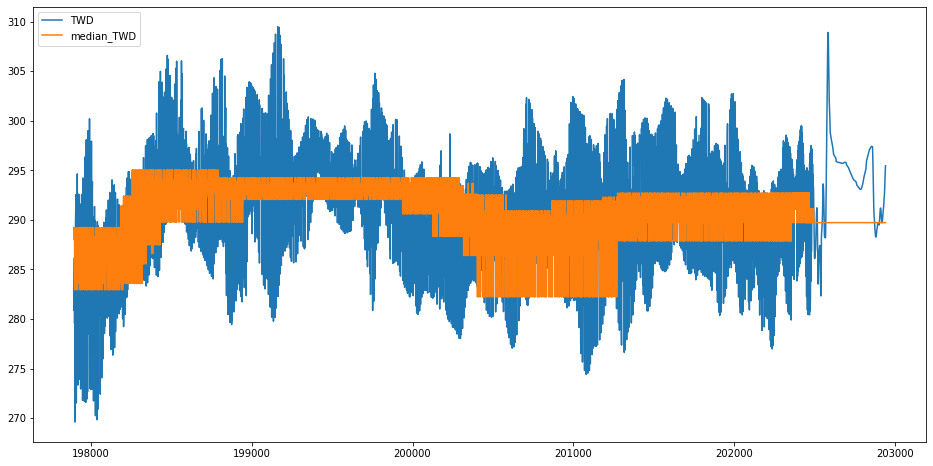

In [11]:
df_dubai_race5[['TWD','median_TWD']].plot(figsize=(16,8))

In [12]:
df_DEN_dubai5=df_dubai_race5[['TWD','median_TWD','TRK_LEG_NUM_unk','BOAT']].loc[df_dubai_race5['BOAT']=='DEN']

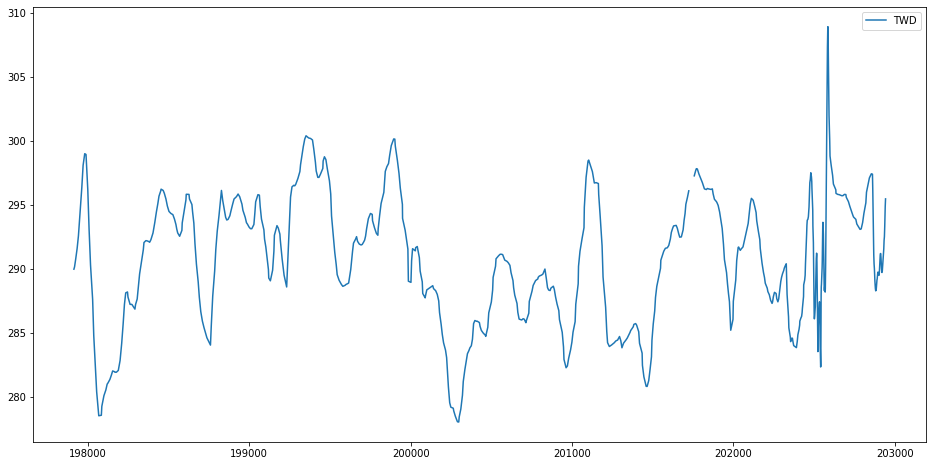

In [13]:
df_DEN_dubai5[['TWD']].plot(figsize=(16,8))

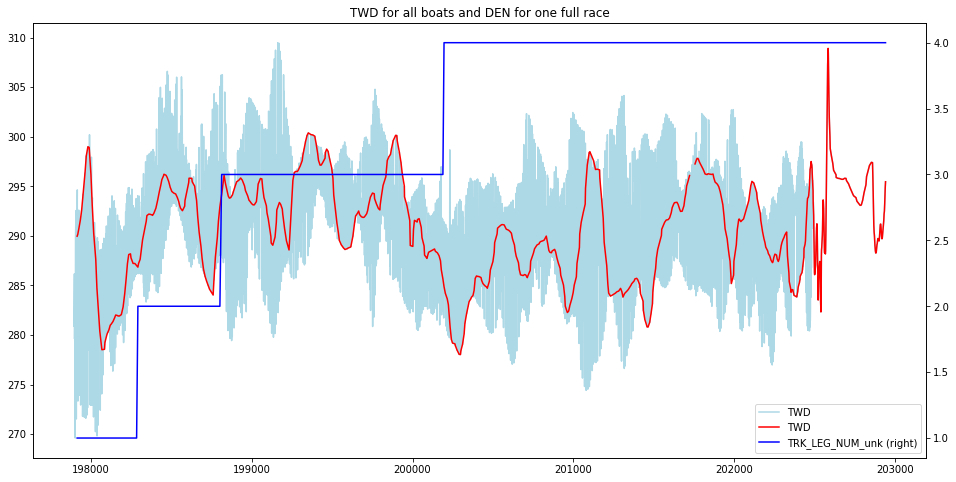

In [14]:
import matplotlib.pyplot as plt # Impot the relevant module

fig, ax = plt.subplots(figsize=(16,8)) # Create the figure and axes object




# Plot the first x and y axes:
df_dubai_race5.plot( y = 'TWD', ax = ax,color='lightblue')
# Plot the first x and y axes:
df_DEN_dubai5.plot( y = 'TWD', ax = ax, color='r')

# Plot the second x and y axes. By secondary_y = True a second y-axis is requested:
# (see https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html for details)
df_DEN_dubai5.plot(y = 'TRK_LEG_NUM_unk', ax = ax, secondary_y = True,color='b') 
plt.title('TWD for all boats and DEN for one full race')
plt.savefig('twdDEN.jpg')

# 3 Create a column that determinnes if boat is passed half way (has gybes on the first downwind) 

In [15]:
#Insert a new column in dataframe IF it is after the gybe on first down wind 
boat_number =df1['BOAT'].unique()
race_number = df1['TRK_RACE_NUM_unk'].unique()
leg_number = df1['TRK_LEG_NUM_unk'].unique()

TWD_df = pd.DataFrame()
second_half_leg2 = pd.DataFrame()
df_second_half_leg2= pd.DataFrame(columns=['TRK_RACE_NUM_unk', 'BOAT', 'TWD','second_half_leg2'])

for raceid in race_number:
    for boatid in boat_number:
        data_to_use = df1.loc[df1['TRK_LEG_NUM_unk']==2]
        data_to_use = data_to_use.loc[data_to_use['TRK_RACE_NUM_unk']==raceid]
        data_to_use = data_to_use.loc[data_to_use['BOAT']==boatid].reset_index(drop=True)
#         print(data_to_use)
        for row in range(len(data_to_use)):
#             print(row)
            if data_to_use['TWA'][row]<=-90:
        #Define the listst after the first gybe:
                TWD_liste = list(data_to_use['TWD'][row:-1])
                length = len(TWD_liste)
                liste_med_1_taller = [1]*length
                
                ras = list(data_to_use['TRK_RACE_NUM_unk'][row:-1])
                bod = list(data_to_use['BOAT'][row:-1])
                legg = list(data_to_use['TRK_LEG_NUM_unk'][row:-1])
        # Create dataframe with the listst
                df2 = pd.DataFrame({'TRK_RACE_NUM_unk': ras,
                    'TRK_LEG_NUM_unk':legg,
                    'BOAT': bod,
                    'TWD': TWD_liste,
                    'second_half_leg2':liste_med_1_taller})
#       Insert the dataframes in the existing dataframe. 
                df_second_half_leg2=df_second_half_leg2.append(df2,ignore_index = True)

                break
                

                


In [16]:
df1= pd.merge(df1,df_second_half_leg2,on=['TRK_RACE_NUM_unk','TRK_LEG_NUM_unk','BOAT','TWD'], how='left')

# 4. Can we call gate bias on the reach? 
> WE now look at the TWD on the reach vs. the second half of the downwind, to asses whether it is realistic to call gatebias on the reach. 

In [17]:
df1=df1.loc[df1['TRK_RACE_NUM_unk']!=22073104.0]
df1=df1.loc[df1['TRK_RACE_NUM_unk']!=22092403.0]


>Defining a leg 2.5 when the boat has taken the first gybe on first DW

In [18]:
df1 = df1.reset_index()

In [19]:
ny_liste = []
for row in range(len(df1)):
    if df1['second_half_leg2'][row]== 1:
        ny_liste.append(2.5)
#         print(ny_liste)
    elif np.isnan(df1['second_half_leg2'][row]) and df1['TRK_LEG_NUM_unk'][row]== 2 :
        ny_liste.append(2.1)
#         print(ny_liste)
    else:
        ny_liste.append(df1['TRK_LEG_NUM_unk'][row])
        
df1['TRK_LEG_NUM_unk_new']=ny_liste

> WE start by calculating diff in angle between reach and first downwind

In [20]:
#Have to make the avg of straight sailing, so removing tacks and gybes!

max_TWA_DW = 150
min_TWA_DW= 110
max_TWA_UW = 70
min_TWA_UW= 40


#Making sure that odd TWA's are not included, so that ex. tacks and gybes are exclusice. 
df1_DW= df1.loc[df1['TRK_LEG_NUM_unk'].isin([2,4])]
df1_DW = df1_DW.loc[df1_DW['TWA'].abs()>=abs(min_TWA_DW)]
df1_DW = df1_DW.loc[df1_DW['TWA'].abs()<=abs(max_TWA_DW)]



#Making sure that odd TWA's are not included, so that ex. tacks and gybes are exclusice. 
df1_UW= df1.loc[df1['TRK_LEG_NUM_unk'].isin([3,5])]
df1_UW = df1_UW.loc[df1_UW['TWA'].abs()>=abs(min_TWA_UW)]
df1_UW = df1_UW.loc[df1_UW['TWA'].abs()<=abs(max_TWA_UW)]


In [21]:
df11 = df1[['TRK_RACE_NUM_unk','TRK_LEG_NUM_unk','TWD','median_TWD','u_wind_vectorTWD',
       'v_wind_vectorTWD']].groupby(['TRK_RACE_NUM_unk','TRK_LEG_NUM_unk']).mean()

df11_2 = df1_DW[['TRK_RACE_NUM_unk','TRK_LEG_NUM_unk_new','TWD','median_TWD','u_wind_vectorTWD',
       'v_wind_vectorTWD']].groupby(['TRK_RACE_NUM_unk','TRK_LEG_NUM_unk_new']).mean()

In [22]:
df11=df11.droplevel('TRK_RACE_NUM_unk').reset_index()
df11_2=df11_2.droplevel('TRK_RACE_NUM_unk').reset_index()

In [23]:
df11_1=df11.loc[df11['TRK_LEG_NUM_unk'].isin([1])]

#Looking at 2nd half of dw
df11_2=df11_2.loc[df11_2['TRK_LEG_NUM_unk_new'].isin([2.5])] 

In [24]:
leg_1_uvec=list(df11_1['u_wind_vectorTWD'])
leg_1_vvec=list(df11_1['v_wind_vectorTWD'])

leg_2_uvec=list(df11_2['u_wind_vectorTWD'])
leg_2_vvec=list(df11_2['v_wind_vectorTWD'])


In [25]:
race_number= list(df1['TRK_RACE_NUM_unk'].unique())

In [26]:
# initialize data of lists.
data = {'TRK_RACE_NUM_unk': race_number,
        'leg_1_uvec':leg_1_uvec,
        'leg_1_vvec':leg_1_vvec,
        'leg_2_uvec':leg_2_uvec,
        'leg_2_vvec': leg_2_vvec}


In [27]:
df_TWD_reach = pd.DataFrame(data)

>Now calculating the angle difference from TWD when on each and TWD when on downwind leg2

In [28]:
# Calculating the angle between leg 1 and leg 2 wind vectors
# Input is the dataframe and the two wind vectors
# Output is the new dataframe with a new column

#OBS: If the angle is clockwise it will show negative, otherwise positive angles. 

def calc_angle(data):
    diff = []
    for row in range(len(data)): 
        vec1= [data['leg_1_uvec'][row],data['leg_1_vvec'][row]]
        vec2 = [data['leg_2_uvec'][row],data['leg_2_vvec'][row]]
        difference = round(py_ang(vec1,vec2),1)
        diff.append(difference)
    data['diff_reach_leg2'] = diff
            


    return(data)

In [29]:
df_diff_reach_leg2=calc_angle(df_TWD_reach)

In [30]:
df_diff_reach_leg2

,TRK_RACE_NUM_unk,leg_1_uvec,leg_1_vvec,leg_2_uvec,leg_2_vvec,diff_reach_leg2
0,22061801.0,3.934001,-24.356298,4.257804,-24.548935,0.7
1,22061802.0,0.855803,-27.353646,-1.051711,-27.654589,-4.0
2,22061803.0,2.529882,-27.438885,1.093993,-27.625467,-3.0
3,22061904.0,-15.977495,-1.688488,-15.327367,-1.022084,-2.2
4,22061905.0,-16.525504,-1.800799,-14.550486,-1.061112,-2.0
5,22073001.0,7.724538,23.095119,7.767104,23.762717,0.4
6,22073002.0,14.722592,18.838226,16.265824,19.681894,-1.6
7,22073003.0,18.561499,13.348451,20.236964,15.475934,1.7
8,22073105.0,13.681480,4.302858,15.808821,6.297858,4.3
9,22082001.0,-0.786804,-24.740149,-6.513796,-26.080696,-12.2


>Most of the diffences in angles aer negative, meaning that TWD on leg 2 is more right than TWD on the reach. That might be a coincidence or it might be because the reach is faster, hence the apparent wind direction is coming more in fron of the boat. Even though there are mechanisms that are ment to calibrate for this, they might not do a proper job? 
>
>At least we now got the fifference from reach to downwind. THe angle is not insignificant.. 

# 5. Call gate bias on same leg but before first gybe downwind?
>Now, let us divide the TWD into first half of DW and second half, and see if the difference in TWD is lower than seen above. We only look at the first LW mark rounding, meaning that we are only looking at leg 2. 

In [31]:
df1=df1.reset_index()

>We start by defining when you are half way down the downwind (when you have taken the first gybe)

In [32]:
ny_liste = []
for row in range(len(df1)):
    if df1['second_half_leg2'][row]== 1:
        ny_liste.append(2.5)
#         print(ny_liste)
    elif np.isnan(df1['second_half_leg2'][row]) and df1['TRK_LEG_NUM_unk'][row]== 2 :
        ny_liste.append(2.1)
#         print(ny_liste)
    else:
        ny_liste.append(df1['TRK_LEG_NUM_unk'][row])
        
df1['TRK_LEG_NUM_unk_new']=ny_liste

In [33]:
#Making sure that odd TWA's are not included, so that ex. tacks and gybes are exclusice. 
df1_DW= df1.loc[df1['TRK_LEG_NUM_unk'].isin([2,4])]
df1_DW = df1_DW.loc[df1_DW['TWA'].abs()>=abs(min_TWA_DW)]
df1_DW = df1_DW.loc[df1_DW['TWA'].abs()<=abs(max_TWA_DW)]

In [34]:
df11 = df1[['TRK_RACE_NUM_unk','TRK_LEG_NUM_unk','TWD','median_TWD','u_wind_vectorTWD',
       'v_wind_vectorTWD','TRK_LEG_NUM_unk_new']].groupby(['TRK_RACE_NUM_unk','TRK_LEG_NUM_unk_new']).mean()

In [35]:
df11=df11.droplevel('TRK_RACE_NUM_unk').reset_index()

In [36]:
# df11_1=df11.loc[df11['TRK_LEG_NUM_unk_new'].isin([1])]

# df11_2=df11.loc[df11['TRK_LEG_NUM_unk'].isin([2])] 
df11_2_1=df11.loc[df11['TRK_LEG_NUM_unk_new'].isin([2.1])]
df11_2_2=df11.loc[df11['TRK_LEG_NUM_unk_new'].isin([2.5])]

In [37]:

leg_2_1_uvec=list(df11_2_1['u_wind_vectorTWD'])
leg_2_1_vvec=list(df11_2_1['v_wind_vectorTWD'])

leg_2_2_uvec=list(df11_2_2['u_wind_vectorTWD'])
leg_2_2_vvec=list(df11_2_2['v_wind_vectorTWD'])

In [38]:
# initialize data of lists.
data = {'TRK_RACE_NUM_unk': race_number,
        'leg_2_1_uvec':leg_2_1_uvec,
        'leg_2_1_vvec': leg_2_1_vvec,
        'leg_2_2_uvec':leg_2_2_uvec,
        'leg_2_2_vvec': leg_2_2_vvec}

In [39]:
df_TWD_leg2 = pd.DataFrame(data)

>An now calculating the angle between first half of leg 2 and second half: 

In [40]:
# Calculating the angle between leg 1 and leg 2 wind vectors
# Input is the dataframe and the two wind vectors
# Output is the new dataframe with a new column

#OBS: If the angle is clockwise it will show negative, otherwise positive angles. 

def calc_angle(data):
    diff = []
    for row in range(len(data)): 
        vec1= [data['leg_2_1_uvec'][row],data['leg_2_1_vvec'][row]]
        vec2 = [data['leg_2_2_uvec'][row],data['leg_2_2_vvec'][row]]
        difference = round(py_ang(vec1,vec2),1)
        diff.append(difference)
    data['diff_leg2.1_leg2.5'] = diff
            


    return(data)

In [41]:
df_diff_leg2_1_leg2_5=calc_angle(df_TWD_leg2)
df_diff_leg2_1_leg2_5

,TRK_RACE_NUM_unk,leg_2_1_uvec,leg_2_1_vvec,leg_2_2_uvec,leg_2_2_vvec,diff_leg2.1_leg2.5
0,22061801.0,4.480245,-23.744285,4.310547,-24.890035,-0.9
1,22061802.0,0.242940,-25.622786,-0.816700,-28.370518,-2.2
2,22061803.0,2.223471,-25.735286,0.892637,-29.142703,-3.2
3,22061904.0,-16.309558,-1.560618,-14.849461,-1.048059,-1.4
4,22061905.0,-15.298765,-1.238915,-13.710164,-0.633880,-2.0
5,22073001.0,8.000804,22.212333,7.696613,23.677831,1.8
6,22073002.0,15.579137,17.635698,15.849705,19.903397,2.9
7,22073003.0,19.843884,13.989200,19.893186,15.505324,2.8
8,22073105.0,17.094461,8.502113,14.517296,5.700748,-5.0
9,22082001.0,-7.127467,-24.091804,-6.231645,-26.629574,3.3


In [42]:

tralalala = pd.DataFrame({'TRK_RACE_NUM_unk':df_diff_leg2_1_leg2_5['TRK_RACE_NUM_unk'],
                          'diff_leg2.1_leg2.5':df_diff_leg2_1_leg2_5['diff_leg2.1_leg2.5'],
                         'diff_reach_leg2':df_diff_reach_leg2['diff_reach_leg2']})


In [43]:
import pandas as pd
import dataframe_image as dfi
tralalala=np.round(tralalala[['diff_leg2.1_leg2.5','diff_reach_leg2']].describe(),1)
dfi.export(tralalala, 'diffTWD.jpg')
tralalala

,diff_leg2.1_leg2.5,diff_reach_leg2
count,26.0,26.0
mean,-0.5,-2.2
std,3.4,4.7
min,-5.0,-12.2
25%,-2.7,-4.3
50%,-1.4,-2.0
75%,1.4,0.6
max,8.1,9.1


> If we look at the statistics above, we can see that it is more sage to call the gate bias after the first gybe on the downwind than already on the reach. We can see that the std is smaller, the max and min are smaller and the general mean value is smaller. Hence all the numbers point to this being the safer choice. 

# 6. Conclusion

>The difference in TWD between the first half of leg2 and the second half of leg2 is less than the difference between the reach and leg2. In addition, the std is less. The mean angle difference from the reach to leg2 is 2.2 degrees. If the gate is 200 meters long, that is potentially 21 meters difference in meters won, which is an amount to consider, however, the numbers indicate that it is fair to estimate the gate bias at this point. The first half of the leg, however, is still time enough to tactically put the boat in a good position for a gate mark rounding, and calling the gate bias before the first gybe on the same leg as the gate is most reliable
